In [1]:
import numpy as np
import cma

## Define deviated environments

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

### Visualize gym helpers

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import time
import imageio
%matplotlib inline


# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    title = plt.title(f"{env.spec.id}\nEp.: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    if done:
        plt.setp(title, color='r')
    else:
        plt.setp(title, color='k')
    img.set_data(env.render(mode='rgb_array'))
    fig = plt.gcf()
    display.display(fig)
    display.clear_output(wait=True)
    
    return np.asarray(fig.canvas.buffer_rgba())

def visual_experiment(env, next_action, max_episode_steps=100, reset_to=None, visualize_in_notebook=True,
                      sleep=0.01, save_gif=None, model_reset=None):
    if reset_to is not None:
        obs = env.reset_to(reset_to)
    else:
        obs = env.reset()
    
    if model_reset is not None:
        model_reset()
    
    if save_gif is not None:
        gif = []
    else:
        gif = None

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    total_reward = 0.0
    for step in range(1, max_episode_steps+1):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

        if visualize_in_notebook:
            fig_data = update_fig(img, env, 1, step, total_reward, done)
            if save_gif is not None:
                gif.append(fig_data)
        else:
            env.render()

        if sleep > 0.0:
            time.sleep(sleep)
    
    if save_gif is not None:
        imageio.mimsave(save_gif, [data for data in gif], fps=10)

## Helper functions

In [4]:
def scale_x(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize_x(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

In [5]:
def visualize_deviated_env(x, reset_to, save_gif=None):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    visual_experiment(env, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps,
                      reset_to=reset_to, save_gif=save_gif)
    env.close()

## Define PID Agent

In [6]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

## Define STL robustness estimation functions

In [7]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

### Estimate robustness by random sampling

In [8]:
def random_sample(env, next_action, max_episode_steps=100, max_episodes=3, model_reset=None):
    space = env.observation_space
    episode_obs_records = []

    for episode in range(max_episodes):
        obs = env.reset()
        
        if model_reset is not None:
            model_reset()
        
        obs_records = [obs]
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            obs_records.append(np.clip(obs, space.low, space.high))

        episode_obs_records.append(obs_records)

    return np.array(episode_obs_records)

In [9]:
# input x is in the original domain
def estimate_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)

    records = random_sample(
        env,
        next_action,
        max_episode_steps=max_episode_steps,
        max_episodes=max_episodes,
        model_reset=model_reset
    )

    env.close()
    return compute_STL_robustness(records).min()

# wrapped constraints function where input x is in [0, 1] and should be scaled to the original domain
def scaled_estimate_min_STL_robustness(x):
    return estimate_min_STL_robustness(scale_x(x, env_bounds))

### Estimate min robustness by using CMA-ES by varying the initial state

In [10]:
# define the range of the initial set
init_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

In [11]:
def episode_by_init(env, x, next_action, max_episode_steps, model_reset=None):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    
    if model_reset is not None:
        model_reset()
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        obs_records.append(np.clip(obs, space.low, space.high))
    
    return np.array(obs_records)


def cma_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y, next_action, model_reset=model_reset, max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': min_STL_robustness_target,
         'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest, scale_x(min_x, init_range)

def scaled_cma_min_STL_robustness(x):
    fbest, _ = cma_min_STL_robustness(scale_x(x, env_bounds))
    return fbest

### Problem configurations

In [12]:
# define variables and their bounds
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]
env_bounds = np.array([
    masscart,
    force_mag
])

# define objective function
x_original = [
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
]

In [13]:
seed = 19279
model = PID()
next_action = lambda obs: model.next_action(obs)
model_reset = lambda : model.reset()
max_episode_steps = 200
max_episodes = 100
min_STL_robustness_target = 0.0

### Compare two sampling methods

In [14]:
# CMA is better when the agent is deterministic
for x in np.random.rand(3, 2):
    est1 = scaled_estimate_min_STL_robustness(x)
    est2 = scaled_cma_min_STL_robustness(x)
    if est1 < est2:
        print(est1, est2, "Random Sample")
    else:
        print(est1, est2, "CMA")

0.15897166146154854 0.15844509540315124 CMA
0.1542974912952945 0.15340507192726585 CMA
0.10685898525829765 0.10808980627174827 Random Sample


### The agent should be safe under the original environment by falsification

In [15]:
fbest, _ = cma_min_STL_robustness(x_original); fbest > 0.0

True

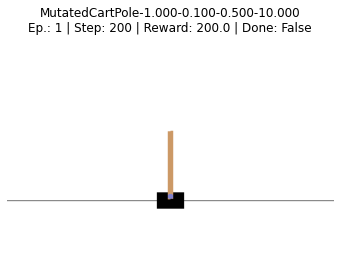

In [16]:
visualize_deviated_env(x_original, [0.0, 0.0, 0.0, 0.0], "gifs-PID/default_env.gif")

In [17]:
# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale_x(x, env_bounds))

### CMA for minimizing the STL robustness value given the bounded deviation

In [35]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.4

_, es1 = cma.fmin2(
    scaled_cma_min_STL_robustness,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'ftarget': min_STL_robustness_target, 'tolstagnation': 0,
     'tolx': 1e-5, 'timeout': 30 * 60},
)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=173498, Thu Jul 28 16:45:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.651083542223427e-02 1.0e+00 4.96e-01  5e-01  6e-01 0:07.1
    2     12 1.346592022295448e-02 1.5e+00 4.46e-01  4e-01  5e-01 0:14.3
    3     18 -2.400000190734863e+00 1.6e+00 4.75e-01  5e-01  6e-01 0:21.4
    4     24 -2.400000190734863e+00 2.4e+00 4.54e-01  4e-01  6e-01 0:28.6
    5     30 -2.400000190734863e+00 2.3e+00 3.44e-01  3e-01  3e-01 0:35.8
    6     36 -2.400000190734863e+00 2.3e+00 2.99e-01  2e-01  3e-01 0:42.7
    7     42 6.794213665838691e-02 2.2e+00 3.70e-01  4e-01  4e-01 0:49.8
    8     48 9.859526289658277e-03 3.2e+00 4.07e-01  4e-01  4e-01 0:56.9
   10     60 -2.400000190734863e+00 2.7e+00 4.73e-01  4e-01  6e-01 1:10.9
   12     72 -9.741688357476738e-02 3.7e+00 5.08e-01  5e-01  7e-01 1:24.9
   14     84 -5.163559900407341e-02 4.5e+00 5.75e-01  4e-01  6e-01 1:39.1
   16     96 -6.266081915978

In [36]:
es1.result

CMAEvolutionStrategyResult(xbest=array([0.71141125, 0.13476059]), fbest=-2.4000001907348634, evals_best=16, evaluations=247, iterations=41, xfavorite=array([0.00095192, 0.93171928]), stds=array([0.00017339, 0.00019832]), stop={'tolflatfitness': 1})

In [37]:
x = es1.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.45168138 3.56045115]
Deviation distance: 6.455370283022994
Counterexample initial state: [-0.03445519 -0.00957374 -0.04997403 -0.04981033]
Counterexample robustness value: -2.4000001907348634


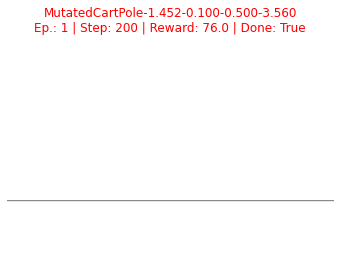

In [38]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-PID/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated (robustness value <= 0)

In [22]:
timeout = 30
num_tries = 3
min_dev = np.inf
min_x = None
for i in range(num_tries):
    print(f'\n================ Trial {i} ==============>')
    # set initial variable values to the default value
    x0 = normalize_x(x_original, env_bounds)
    sigma0 = 0.2

    cfun2 = cma.ConstrainedFitnessAL(
        scaled_deviation_dist,
        lambda x: [scaled_cma_min_STL_robustness(x)],
        find_feasible_first=True
    )
    _, es2 = cma.fmin2(
        cfun2,
        x0,
        sigma0,
        {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5,
         'timeout': timeout / num_tries * 60},
        callback=cfun2.update
    )
    
    print(es2.result)
    print(cfun2.best_feas.info)
    
    x = cfun2.best_feas.info['x']
    dev = deviation_dist(scale_x(x, env_bounds))
    if dev < min_dev:
        min_dev = dev
        min_x = x


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=115679, Thu Jul 28 15:34:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.510390622080425e-02 1.0e+00 2.13e-01  2e-01  2e-01 0:07.2


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


    2     12 2.510390622080425e-02 1.4e+00 1.96e-01  2e-01  2e-01 0:13.4
    3     18 5.267015255218731e-01 1.3e+00 1.62e-01  1e-01  1e-01 0:20.6


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 1.900212741789046, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    4     24 1.054557178166994e+10 1.3e+00 1.37e-01  9e-02  1e-01 0:27.7


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.6065465936284573, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    5     30 6.116279626063672e+09 1.4e+00 1.13e-01  6e-02  9e-02 0:34.9


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.4546742708481526, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    6     36 5.063503465306847e+09 1.5e+00 8.43e-02  4e-02  6e-02 0:42.1


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.4584509191804991, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    7     42 5.092341486867204e+09 1.5e+00 6.56e-02  3e-02  4e-02 0:49.3


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.2576792944796935, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    8     48 3.320367283148100e+09 1.6e+00 5.00e-02  2e-02  3e-02 0:56.7


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.15371263266447044, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))
/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.15942322847431745, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


   10     60 2.230063794468899e+09 1.7e+00 3.77e-02  1e-02  2e-02 1:11.2
   12     72 2.268662904592273e+09 1.7e+00 3.29e-02  1e-02  1e-02 1:25.6
   14     84 2.314565240991628e+09 1.7e+00 2.84e-02  8e-03  9e-03 1:40.0
   16     96 2.369152626042652e+09 1.3e+00 2.95e-02  7e-03  8e-03 1:54.4
   18    108 2.434068332733454e+09 1.3e+00 2.80e-02  6e-03  7e-03 2:09.0
   20    120 2.511266553011823e+09 1.4e+00 2.87e-02  5e-03  6e-03 2:23.3
   22    132 2.603071225837831e+09 1.3e+00 2.86e-02  5e-03  5e-03 2:37.6
   25    150 2.774351201966493e+09 1.2e+00 3.01e-02  4e-03  5e-03 2:59.1
   28    168 2.996473849933048e+09 1.5e+00 3.22e-02  3e-03  5e-03 3:20.5
   31    186 3.284531285808983e+09 1.9e+00 3.49e-02  3e-03  5e-03 3:41.9
   34    204 3.658095562668404e+09 1.6e+00 3.71e-02  3e-03  4e-03 4:03.4
   37    222 4.142548493111605e+09 1.6e+00 3.61e-02  3e-03  3e-03 4:24.9
   40    240 4.770806215682388e+09 1.4e+00 3.61e-02  2e-03  3e-03 4:46.5
   43    258 5.585555680831152e+09 1.3e+00 3.87e-02

In [23]:
# c = es.countiter
# x = cfun.find_feasible(es)
# print("find_feasible took {} iterations".format(es.countiter - c))
# print("Solution:", scale_x(x, env_bounds))
# print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

In [24]:
# plt.rc('font', size=14) 

# es2.plot()

# fig = plt.gcf()
# fig.set_figwidth(18)
# fig.set_figheight(18)

In [25]:
x = min_x
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.1039784  9.98716861]
Deviation distance: 0.8961134730674966
Counterexample initial state: [-0.04691556 -0.04333639 -0.04297644 -0.04152332]
Counterexample robustness value: -0.000367781387610705


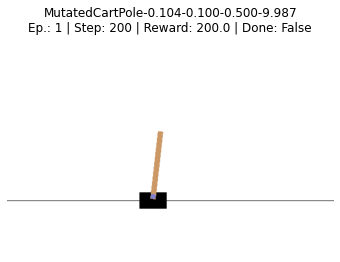

In [26]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-PID/min_dev_counterexample.gif")

### CMA for finding the maximum deviation s.t. the agent is safe

In [27]:
timeout = 30
num_tries = 3
max_dev = -np.inf
max_x = None
for i in range(num_tries):
    print(f'\n================ Trial {i} ==============>')
    
    x0 = normalize_x(x_original, env_bounds)
    sigma0 = 0.2

    cfun3 = cma.ConstrainedFitnessAL(
        lambda x: -scaled_deviation_dist(x), # maximize distance
        lambda x: [-scaled_cma_min_STL_robustness(x)], # robustness >= 0
    #     find_feasible_first=True # assume the initial is already feasible
    )
    _, es3 = cma.fmin2(
        cfun3,
        x0,
        sigma0,
        {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5, 'timeout': timeout / num_tries * 60},
        callback=cfun3.update
    )
    
    print(es3.result)
    print(cfun3.best_feas.info)
    
    x = cfun3.best_feas.info['x']
    dev = deviation_dist(scale_x(x, env_bounds))
    if dev > max_dev:
        max_dev = dev
        max_x = x


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=135081, Thu Jul 28 16:02:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.433611392652935e+00 1.0e+00 1.71e-01  1e-01  2e-01 0:07.8
    2     12 -8.584537345307657e+00 1.2e+00 2.42e-01  2e-01  3e-01 0:14.1


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 1.3421173852196246, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    3     18 -9.804546918423996e+09 2.0e+00 2.05e-01  1e-01  3e-01 0:18.0
    4     24 -9.748513879258162e+09 2.0e+00 2.06e-01  1e-01  3e-01 0:23.3
    6     36 -9.639319101549372e+09 2.9e+00 2.01e-01  1e-01  3e-01 0:32.9
    7     42 -9.589243771616508e+09 2.5e+00 1.89e-01  1e-01  2e-01 0:38.4
    9     54 -9.504380732504374e+09 3.4e+00 1.45e-01  7e-02  1e-01 0:49.6
   11     66 -9.407657027115355e+09 2.9e+00 1.02e-01  4e-02  9e-02 1:02.0
   13     78 -9.304645482336788e+09 2.1e+00 1.16e-01  5e-02  7e-02 1:14.3
   15     90 -9.180162987241432e+09 1.1e+00 1.73e-01  8e-02  1e-01 1:26.7
   17    102 -9.030074792744263e+09 1.6e+00 1.19e-01  4e-02  6e-02 1:39.8
   19    114 -8.851588843372858e+09 1.9e+00 6.95e-02  2e-02  3e-02 1:53.8
   21    126 -8.639332082626059e+09 1.9e+00 5.05e-02  1e-02  2e-02 2:09.0
   23    138 -8.386914832320703e+09 1.5e+00 3.44e-02  6e-03  8e-03 2:24.9
   25    150 -8.086738442471379e+09 1.5e+00 2.40e-02  3e-03  5e-03 2:40.6
   28    168 -7.526699358236145e+09 1.

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 2.7149801414253405, [0.02930939], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    4     24 -1.493542490590002e+01 1.1e+00 1.72e-01  1e-01  2e-01 0:24.5
    6     36 -1.728377749274026e+01 1.2e+00 2.94e-01  3e-01  3e-01 0:34.6
    7     42 -1.465254934654854e+01 1.4e+00 2.59e-01  2e-01  3e-01 0:40.8
    8     48 -1.675299805501942e+01 1.4e+00 2.08e-01  2e-01  2e-01 0:46.9
   10     60 -1.689150119923185e+01 2.0e+00 1.64e-01  1e-01  1e-01 0:58.0
   12     72 -1.678889844241825e+01 2.3e+00 1.26e-01  7e-02  9e-02 1:11.3
   14     84 -1.672013348208498e+01 2.7e+00 7.98e-02  3e-02  5e-02 1:23.8
   16     96 -1.645982561036538e+01 1.9e+00 6.66e-02  2e-02  3e-02 1:36.7
   18    108 -1.628065481435173e+01 2.2e+00 4.51e-02  1e-02  2e-02 1:51.1
   20    120 -1.598787417867324e+01 2.0e+00 2.87e-02  5e-03  1e-02 2:05.5
   22    132 -1.564025000165984e+01 2.2e+00 1.90e-02  3e-03  5e-03 2:21.7
   24    144 -1.524501231158326e+01 2.5e+00 1.73e-02  2e-03  5e-03 2:36.8
   27    162 -1.448910046566055e+01 4.8e+00 1.70e-02  1e-03  5e-03 2:58.4
   30    180 -1.350164603638923e+01 6.

In [28]:
x = max_x
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 0.2320396  19.99998883]
Deviation distance: 10.02943367127679
Counterexample initial state: [-0.03262714 -0.04138455 -0.04981052 -0.01632991]
Counterexample robustness value: 5.522502617566483e-06


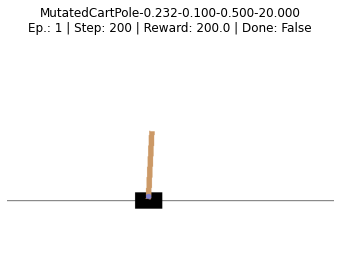

In [29]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs-PID/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

In [30]:
n_mass, n_force = (25, 25)

In [31]:
masses = np.linspace(masscart[0], masscart[1], n_mass)
forces = np.linspace(force_mag[0], force_mag[1], n_force)
masses, forces = np.meshgrid(masses, forces, indexing='ij')

In [32]:
min_STL_robustness_target = -np.inf
grid_data = np.zeros((n_mass, n_force))

for i in range(n_mass):
    for j in range(n_force):
        # treat xv[i,j], yv[i,j]
        m, f = masses[i, j], forces[i, j]
        robustness, _ = cma_min_STL_robustness([m, f])
        grid_data[i, j] = robustness

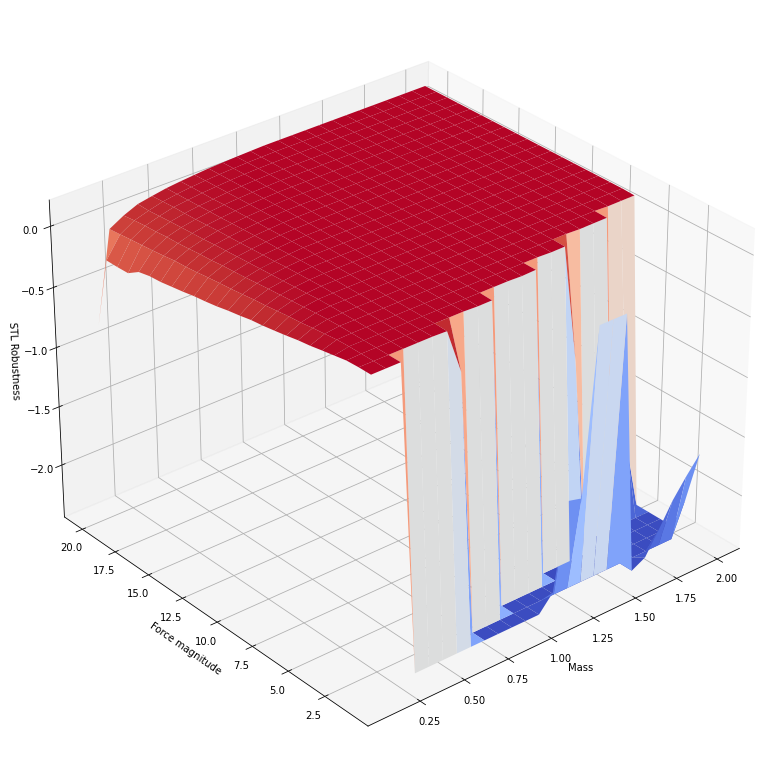

In [52]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm)
ax.set_xlabel('Mass')
ax.set_ylabel('Force magnitude')
ax.set_zlabel('STL Robustness')

ax.view_init(30, -130)
plt.savefig('gifs-PID/robustness-landscape.png')
plt.show()

In [34]:
np.savetxt("pid_data/masses.csv", masses, delimiter=",")
np.savetxt("pid_data/forces.csv", forces, delimiter=",")
np.savetxt("pid_data/grid_data.csv", grid_data, delimiter=",")

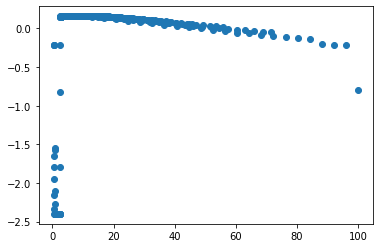

In [39]:
acc = forces / (masses + 0.1)
plt.scatter(acc.flatten(), grid_data.flatten())

### compare with DQN

In [54]:
dqn_grid_data = np.loadtxt("rl_data/grid_data.csv", delimiter=',')

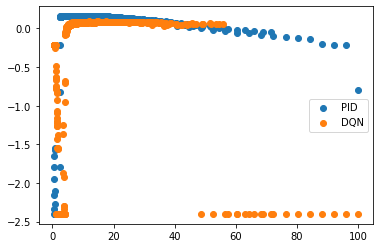

In [59]:
plt.scatter(acc.flatten(), grid_data.flatten(), label='PID')
plt.scatter(acc.flatten(), dqn_grid_data.flatten(), label='DQN')
plt.legend()

### Plot the falsification space of a given environment by varying the initial state